# Création d'un RAG

## Récolte des données et préparations des chunks:

In [33]:
import re
from bs4 import BeautifulSoup
import requests


ai_act_url = "https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689"
soup = BeautifulSoup(requests.get(ai_act_url).content, "html.parser")
text = []
context = []
section_type = []
url = []
url_sections = []
url_chapitres = []


&emsp;La préparation des données et métadonné ce fait ici à l'aide de **BeautifulSoup** et non pas les [**document loaders de LangChain**]() car il nous faut plus de control sur la façon dont on séctionne l'AI Act. 

&emsp; On cherche à le séctionner en fonction de ses *Considerants*, *Chapitres*, *Sections* et *Articles*.

Chacun de ces éléments seront accompagner de métadonnées tel qu'un liens à la séction, le nom du chapitre et de l'article.

In [34]:
# Preambule Parser
considerants = soup.find_all("div", {"class":"eli-subdivision", "id": re.compile(r'rct_\d+')})
text += [considerant.text.strip() for considerant in considerants]
context += [f"Considérant {n+1}" for n in range(len(considerants))]
url += [ai_act_url+f"#rct_{n+1}" for n in range(len(considerants))]
url_sections += [None for _ in range(len(considerants))]
url_chapitres += [ai_act_url+"#pbl_1" for _ in range(len(considerants))]
section_type += ["considerant"]*len(considerants)

In [35]:
#Chapitre Parser
chapitres = soup.find("div", {"id": "enc_1"}).find_all("div", {"id": re.compile(r'cpt_[XVILC]+')}, recursive=False)
articles = []

def get_article_and_article_str(soup_element: BeautifulSoup):
    _articles = soup_element.find_all("div", {"class":"eli-subdivision", "id": re.compile(r'art_\d+')})
    article_strs = [
        f"Art.{article['id'].strip('art_')}-"+article.find("div", {"class": "eli-title"}).text for
        article in _articles
    ]
    return _articles, article_strs

for idx_ch, chapitre in enumerate(chapitres):
    chapitre_url = ai_act_url+f"#{chapitre['id']}"
    chapitre_str = f"Ch.{idx_ch+1}-"+chapitre.find("p", {"class": "oj-ti-section-2"}).text.strip("\n")+" > "
    chapitre_articles =  chapitre.find_all("div", {"class":"eli-subdivision", "id": re.compile(r'art_\d+')})
    url_chapitres += [chapitre_url for _ in range(len(chapitre_articles))]
    text += [article.text.strip() for article in chapitre_articles]
    
    section_str = ""
    sections = chapitre.find_all("div", {"id":re.compile(r'cpt_[XVILC]+.sct_\d+')}, recursive=False)
    
    if sections:
        for idx_sct, section in enumerate(sections):
            _articles, article_strs = get_article_and_article_str(section)
            articles += _articles
            url_sections += [ai_act_url+f"#{section['id']}" for _ in range(len(_articles))]
            section_str = f"Sct.{idx_sct+1}-"+section.find("p", {"class": "oj-ti-section-2"}).text.strip("\n")+" > "
            context += [chapitre_str+section_str+article_str for article_str in article_strs]
    else:
        _articles, article_strs = get_article_and_article_str(chapitre)
        articles += _articles
        context += [chapitre_str+article_str for article_str in article_strs]
        url_sections += [None for _ in range(len(_articles))]
section_type += ["article"]*len(articles)
url += [ai_act_url+f"#art_{n}" for n in range(1,len(articles)+1)]

In [36]:
annexes = soup.find_all("div", {"class": "eli-container", "id": re.compile(r'anx_[XVILC]+')})
titres_annexes = [annexe.find("p", {"class": "oj-doc-ti", "id":None}).get_text() for annexe in annexes]

text += [annexe.text.strip() for annexe in annexes]
context += titres_annexes
section_type += ["annexe"]*len(articles)
url += [ai_act_url+f"#{annexe['id']}" for annexe in annexes]
url_sections += [None for _ in range(len(annexes))]
url_chapitres += [ai_act_url+"##anx_I" for _ in range(len(annexes))]

texts = [f"{context[idx]} \n {text[idx]}" for idx in range(len(text))]
metadatas = [ 
    {
        "titre":context[idx],
        "nature": section_type[idx],
        "url":url[idx],
        "url_chapitre": url_chapitres[idx],
        "url_section": url_sections[idx]
    }
    for idx in range(len(texts))
]

## Préparation des Documents et des chunks avec [RecursiveCharaterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/). 

&emsp;La séléction de la taille des chunks et leurs overlap peut avoir un impact significatif sur la performance de la recherche vectorielle par la suite et donc de la pérformance du RAG par derrieres. 

Ce [guide](https://www.machinelearningplus.com/gen-ai/optimizing-rag-chunk-size-your-definitive-guide-to-better-retrieval-accuracy/#:~:text=Optimal%20chunk%20size%20for%20RAG%20systems%20typically%20ranges,tokens%29%20provide%20better%20context%20for%20complex%20reasoning%20tasks.) donne une idée de structure d'évaluation pour détèrminer les bons paramétres. 

A titre d'example, on vas utiliser des chunks de 256 characters avec un overlap de 10%. Une petite taille de chunk fera de notre RAG un outil paré pour répondre à des questions factuelles.   

In [37]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024, chunk_overlap = int(256*0.1), length_function=len
)

text_chunks: list[Document] = text_splitter.create_documents(texts=texts, metadatas=metadatas)

## Création d'une base vectorielle. 

### Sur une ressource Azure AI Search

In [47]:
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores.azuresearch import AzureSearch
from azure.search.documents.indexes.models import SimpleField, SearchFieldDataType, SearchableField, SearchField
from dotenv import load_dotenv
from globals import EMBEDDINGS
import os
load_dotenv()

# Afin de pouvoir par la suite filtrer par des variables de metadata, on prédéfini les champs de notre index en idiquant lesquels seront filtrable.
# Pour pouvoir par la suite filtrer par "nature", on créé un champs spécifiquement pour.
# Attention, un champ qui est filtrable vas agrandir la taille de l'index crée.   
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True,),
    SearchableField(name="content", type=SearchFieldDataType.String, searchable=True),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single), vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile", searchable=True),
    SearchableField(name="metadata", type=SearchFieldDataType.String, searchable=True, filterable=True),
    SearchableField(name="nature", type=SearchFieldDataType.String, searchable=True, filterable=True),
]

# Création ou Instanciation de la base vectorielle. Si l'index existe pas, il sera créé puis il pourra être utilisé via la variable vector_store, 
vector_store = AzureSearch(
    azure_search_endpoint=os.environ["SEARCH_ENDPOINT"],
    azure_search_key=os.environ["SEARCH_KEY"],
    index_name="lang_rag_index_2",#os.environ["SEARCH_INDEX"],
    embedding_function=EMBEDDINGS.embed_query,
    additional_search_client_options={"retry_total": 4},
    fields=fields
)

# Si l'index vient d'être créé, il faut alors y ajouter les chunks créé auparavent.
vector_store.add_documents(text_chunks)

['Yjc1MDAzOGUtMTM0Yi00MzcwLThjZjUtM2EzYzk2NjE0ZWY2',
 'YjBmNDg2NjYtZTFjYy00M2JhLWE2YTYtMTEzMWVhMGVhMDJl',
 'NWNlZDlhNDgtZjNiMy00M2M5LWExYmUtZTM1NGU4NmFhZjNl',
 'NDUyN2ExYmMtMTJlZC00ZTJlLWJjMGUtNDU1MWRkMDhlMTUw',
 'NGFkZTRjMTUtYWYyNi00ODUyLTliNjItNThiNjkyNGM2NmY0',
 'ODc1MTBkYTQtZTA0NS00NjU1LTg1ZjgtNGYwY2RhNjQ0NDA2',
 'OGM3MDVhMzktZWFmMC00OTMwLWI4YzEtYzY3MmQ1N2E0ZWM4',
 'OWM3MTJiMzEtMWNkZS00MzJmLWI0YzMtMjAwMGRmZGIwNjc1',
 'MDUyZDg0MDEtZTE0OS00NjMwLTlkMWYtNWNkYTkzMmIzOTIy',
 'M2M5ZTU5ZjEtNDlkZS00NzBhLWEwM2YtZDY1ZGQ1NzE5MzJj',
 'OTI0OTgyMDUtZTJlMi00YmMxLTg0NGItNWNkMGNiOWVmMGYw',
 'MGIwY2JlYjgtNWI1Yi00NTk2LWJlNmUtNTgxMGU3NGVhMjg2',
 'NjcwMDA0OWItNDE0ZS00ZWI2LWE3NTQtOTk1MzE5NWVhM2U5',
 'NWVjYzFmZTktMmQxNC00OGFjLWJmYzMtYjk5YjA4OTFmYWIw',
 'NDQ5MDdiNTItNWU0NS00YTNmLWE1YmEtZTVhNzg3MTQyZWYx',
 'NDA4ZmRjZDQtZDY1MS00OWRhLWI3N2YtOGUyYWIyZGVmMTFl',
 'MzE0ZmU5MzctNGIwYy00NjE5LTkxMzctMDAyOTdmOWEwYmY3',
 'MjJmYmVkMTAtNzUzYy00MWMzLWFlOWUtZGY2N2RhZWVlNWY4',
 'YzUwMjJhZjAtN2QyNy00NDU1LWIzYzktY2MzM2U0N2Mx

##### Testez la recherche sémantique

In [8]:
search_docs = vector_store.similarity_search(query="Service payant", k=5)
print("\n\n".join(search_doc.page_content for search_doc in search_docs))

en soi, constituer une monétisation.

Ch.13-DISPOSITIONS FINALES > Art.111-
Systèmes d’IA déjà mis sur le marché ou mis en service et modèles d’IA à usage général déjà mis sur le marché
 
 Article 111

Systèmes d’IA déjà mis sur le marché ou mis en service et modèles d’IA à usage général déjà mis sur le marché


1.   Sans préjudice de l’application de l’article 5 visée à l’article 113, paragraphe 3, point a), les systèmes d’IA qui sont des composants des systèmes d’information à grande échelle établis par les actes juridiques énumérés à l’annexe X et mis sur le marché ou mis en service avant le 2 août 2027 sont mis en conformité avec le présent règlement au plus tard le 31 décembre 2030.
Il est tenu compte des exigences énoncées dans le présent règlement lors de l’évaluation de chaque système d’information à grande échelle établi par les actes juridiques énumérés à l’annexe X devant être effectuée conformément à ces actes juridiques et lorsque ces actes juridiques sont remplacés ou mod

#### Appel Programatique a un LLM
Pour faire appel à un LLM, langchain propose des classe spécifique à chaque LLM (eg Anthropic, OpenAI, [AzureOpenAI](https://python.langchain.com/docs/integrations/chat/azure_chat_openai/#model-features)).

Celles-ci peuvent être instanciées à l'aide des clef API et endpoints nécessaire (voir la doc langchain pour plus de détail).

Comme dit dans le README, on vas utiliser les variable du .env pour instantier une class de chat completion AzureOpenAI 

In [10]:
from langchain_openai import AzureChatOpenAI
from langchain_core.documents import Document
from langchain_core.rate_limiters import InMemoryRateLimiter
from dotenv import load_dotenv
load_dotenv()

rate_limiter = InMemoryRateLimiter(
        requests_per_second=10,
        check_every_n_seconds=0.1,
        max_bucket_size=10
    )

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_API_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    rate_limiter=rate_limiter,
    streaming=True,
    seed=42
)

llm.invoke("Write me a Haiku").content

'Whispering pine trees,  \nMoonlight dances on the lake,  \nNight holds its secrets.'

#### Concéption de Prompts via les [Templates LangChain](https://python.langchain.com/docs/concepts/prompt_templates/)

##### Définition du format des promptes

Afin de properment définire le conpertement d'une application LLM, les **PropmtTemplate** permettent de structuré les instructions et question ingéré par le modéle.

Ici notre prompte doit tenir compte de la question utilisateur et du context renvoyé par la base vectorielle.

In [11]:
from langchain_core.prompts import HumanMessagePromptTemplate, PromptTemplate, ChatPromptTemplate

setup_prompt = ChatPromptTemplate(
    input_variables=['context', 'question'],
    messages=[
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=['context', 'question'], 
                input_types={}, 
                partial_variables={}, 
                template="""
                Tu est un expert legal qui conseil l'utilisateur sur toute question en lien avec l'AI Act. 
                
                En te basant sur le context suivant, répond à la question.  
                Si il n'y à pas de context fourni ou que sont rapport à la question est marginal, précède ta réponse par la note suivante:

                "Ma base de connaissance semble limité pour répondre à votre question, les éléments de réponse suivant doivent être pris avec des pincettes !" 

                \nQuestion: {question}
                \nContext: {context} 
                \Réponse:"""
            ), additional_kwargs={}
        )
    ]
)

<>:21: SyntaxWarning: invalid escape sequence '\R'
<>:21: SyntaxWarning: invalid escape sequence '\R'
C:\Users\HugoRECHATIN\AppData\Local\Temp\ipykernel_2604\3306373742.py:21: SyntaxWarning: invalid escape sequence '\R'
  \Réponse:"""


#### State Graph

Le **StateGraph** de [**LangGraph**](https://langchain-ai.github.io/langgraph/?_gl=1*q59ke1*_gcl_au*MTM1MDQ3OTk4OS4xNzUwODU3NDI4*_ga*NjYwNjA0NDQ4LjE3NDU0MTg0NTA.*_ga_47WX3HKKY2*czE3NTE2MzkyMTUkbzU0JGcxJHQxNzUxNjM5MjE1JGo2MCRsMCRoMA..) sert à coordonner les requétes et réponse du *LLM* et du *Retriver*.  

Les StateGraph sont des machines d'états avec les quelles on peut agencé les differents appel llm en fonction d'une séquence d'Etats. Chaque Etat vas éxecuter un code et modifié les valeurs de l'état.

La séquence ainsi défini permet d'assurer que les appels llm ne s'empiete pas.

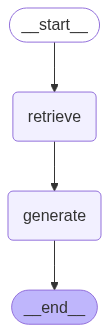

In [12]:
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from langchain_community.vectorstores.azuresearch import AzureSearchVectorStoreRetriever
from IPython.display import Image, display


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

retriever: AzureSearchVectorStoreRetriever = vector_store.as_retriever()

def retrieve(state: State):   
    """Appel vers la base vectorielle """
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n".join(doc.page_content for doc in state["context"])
    messages = setup_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag = graph_builder.compile()

# On peut obtenir un schémas de notre machine d'états grâce à la ligne suivante.
display(Image(rag.get_graph().draw_mermaid_png()))

#### Tester le RAG
On peut utiliser le stream avec le mode **update** afin d'observer la progression de notre requetes à travers le graph d'états. 

In [ ]:
for step in rag.stream(
    {"question": "Quels articles address l'application d'algorithme de reconnaissance facial ?"},
    stream_mode="updates"
):
    print(step)

{'retrieve': {'context': [Document(metadata={'id': 'NmI3NzM5ZTctODdlYy00NzlhLWE2YjQtMTE1ZjBjNjZmMzFi', 'titre': 'Ch.4-OBLIGATIONS DE TRANSPARENCE POUR LES FOURNISSEURS ET LES DÉPLOYEURS DE CERTAINS SYSTÈMES D’IA > Art.50-\nObligations de transparence pour les fournisseurs et les déployeurs de certains systèmes d’IA\n', 'nature': 'article', 'url': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#art_50', 'url_chapitre': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#cpt_IV', 'url_section': None}, page_content='3.\xa0\xa0\xa0Les déployeurs d’un système de reconnaissance des émotions ou d’un système de catégorisation biométrique informent les personnes physiques qui y sont exposées du fonctionnement du système et traitent les données à\xa0caractère personnel conformément au règlement (UE) 2016/679, au règlement (UE) 2018/1725 et à\xa0la directive (UE) 2016/680, selon le cas. Cette obligation ne s’applique pas aux systèmes d’IA utilisés pou

In [28]:
print(rag.invoke({"question": "Selon l'ai act est il légale d'utilisé un modéle de reconnaissance facial et si oui dans quelles circonstance. Répond avec les citation aux informations donné par le context."})["answer"])

Selon le contexte fourni, l'utilisation des systèmes de reconnaissance faciale sous le cadre de l'AI Act est soumise à des restrictions strictes et ne peut être considérée comme légale que dans des circonstances spécifiques. Voici les principaux points tirés du contexte :

1. **Obligation d'information et conformité aux règlements** :
   Les déployeurs de systèmes de reconnaissance faciale doivent informer les personnes exposées au fonctionnement de ces systèmes. En outre, ils doivent traiter les données personnelles conformément aux réglementations en vigueur, notamment le **Règlement Général sur la Protection des Données (RGPD)** (UE 2016/679), le règlement (UE) 2018/1725 et la directive (UE) 2016/680 concernant les données personnelles.

   Cependant, cette obligation **ne s'applique pas aux systèmes utilisés dans un cadre légal** à des fins de prévention ou détection des infractions pénales, ou pour des enquêtes en la matière. Dans ce cas, des garanties appropriées doivent être pré

#### Prochaines étapes:
Pour les prochains points consultez les fichiers rag_chat.py et rag_simple.py 
- Ajouter un **analyste de question utilisateurs** pour les convertir en requettes de recherche vectoriel pertinentes. 
- Formatter les réponses du RAG de sorte à ce que les liens vers les séctions de l'ai act y soit clickable
- Créer une application chat standard via Streamlit
- Ajouter une fenêtre contextuelle pour que les questions puissent référer la chaines de messages.

#### rag_simple

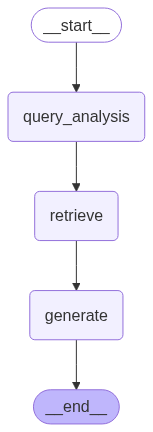

In [48]:
from rag_simple import get_compiled_rag

rag = get_compiled_rag()

display(Image(rag.get_graph().draw_mermaid_png()))

#### rag_chat

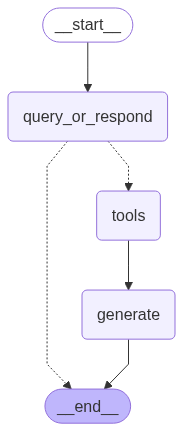

In [56]:
from rag_chat import get_compiled_rag

rag = get_compiled_rag()

display(Image(rag.get_graph().draw_mermaid_png()))

Vue que ce RAG est composé d'une chaine de **messages LangChaines** on peut streamer la réponse à notre requéte en utilisant BaseMessage.pretty_print

In [57]:
from time import time
config = {"configurable": {"thread_id": f"{time()}"}}
for step in rag.stream(
    {
        "messages":[
            {"role": "user", "content": "Quels annexes address l'application d'algorithme de reconnaissance facial ?"}
        ]
    },
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Quels annexes address l'application d'algorithme de reconnaissance facial ?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_hOr6bUY4rpnf6JyDFxFZdQyt)
 Call ID: call_hOr6bUY4rpnf6JyDFxFZdQyt
  Args:
    query: applications de l'algorithme de reconnaissance facial
================================= Tool Message =================================
Name: retrieve

Source: {'id': 'NmI3NzM5ZTctODdlYy00NzlhLWE2YjQtMTE1ZjBjNjZmMzFi', 'titre': 'Ch.4-OBLIGATIONS DE TRANSPARENCE POUR LES FOURNISSEURS ET LES DÉPLOYEURS DE CERTAINS SYSTÈMES D’IA > Art.50-\nObligations de transparence pour les fournisseurs et les déployeurs de certains systèmes d’IA\n', 'nature': 'article', 'url': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#art_50', 'url_chapitre': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#cpt_IV', 'ur